In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
import matplotlib.pyplot as plt

## Importar modelo/s

In [2]:
with open('models/model_enfermeras_covid.pkl','rb') as f:
    modelo_enfermeria_arima=pickle.load(f)

In [3]:
with open('models/model_enfermeras_plantilla.pkl','rb') as f:
    modelo_plantilla_profet=pickle.load(f)

In [4]:
with open('models/model_enfermeras_google.pkl','rb') as f:
    modelo_google_arima=pickle.load(f)

In [5]:
#Importamos dataset
df = pd.read_csv('output/Enfer.csv', sep=',',encoding='latin1',decimal=".")
ts=df.set_index('date').drop(['index','COLECTIVO','mes','año'],axis=1)

In [6]:
#Importamos dataset covid
covid_badalona=pd.read_csv('data/casos_covid.csv', sep=',',encoding='latin1',decimal=".")

In [7]:
ts_covid=covid_badalona.set_index('date')

## Predicción valores exógenos

### Predicción plantilla

In [8]:

ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})
yhat=modelo_plantilla_profet.predict(ds).yhat
exogenos=pd.DataFrame(data=yhat.to_numpy(),index=ds['ds'],columns=['Plantilla'])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Predicción casos covid en base evolución Sudafrica

In [9]:
covid_sudafrica = pd.read_csv('data/covid_sudafrica.csv', sep=';',encoding='latin1',header=[0])

In [10]:
#creo funciones para extraer dia, mes y año:
def extraer_dia(x):
    return x.split("/")[0]

def extraer_mes(x):
    return x.split("/")[1]

def extraer_año(x):
    return x.split("/")[2]

In [11]:
#extraigo dia, mes y año
covid_sudafrica['dia']=covid_sudafrica['Fecha'].apply(extraer_dia).astype('int')
covid_sudafrica['mes']=covid_sudafrica['Fecha'].apply(extraer_mes).astype('int')
covid_sudafrica['año']=covid_sudafrica['Fecha'].apply(extraer_año).astype('int')


In [12]:
#Añadimos columna fecha agrupada
covid_sudafrica['date_agr'] = pd.to_datetime(
    dict(
        year=covid_sudafrica['año'], 
        month=covid_sudafrica['mes'], 
        day=1
    )
)

In [13]:
#observamos tendencia ola omicron en sudafrica
covid_sudafrica.groupby('date_agr')['Var.'].sum()

date_agr
2021-11-01     45936
2021-12-01    490234
2022-01-01    146936
2022-02-01     68820
2022-03-01     26442
Name: Var., dtype: int64

In [14]:
#comparamos con la ola en Badalona
ts_covid.tail(3)

,numcasos
date,
2022-01-01,77899
2022-02-01,14788
2022-03-01,4722


In [15]:
## Hacemos una predicción de casos covid en Badalona en función de la tendencia de Sudafrica
prediccion_covid=[7300,3600,1500,750,660,600,550,660,1000,3000]
exogenos['casos_covid']=np.array(prediccion_covid)

### Cambio normativa

In [16]:
exogenos['cambio_normativa']=np.zeros((10,), dtype=int)
#exogeno_normativa=pd.DataFrame(data=np.zeros((10,), dtype=int),index=ds['ds'],columns=['cambio_normativa'])

### Festivos_intersemanales

In [17]:
festivos_intersemanales=[0,2,1,2,0,1,0,1,1,3]
exogenos['Festivos_intersemanales']=np.array(festivos_intersemanales)

### Predicción búsquedas google

In [18]:
histórico_google=ts[['busquedas_google']][32:] #desde septiembre de 2005

In [19]:
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = modelo_google_arima.order 
sparams = modelo_google_arima.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodelo_google_arima = SARIMAX(histórico_google, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results_google=smodelo_google_arima.fit(maxiter=100)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [20]:
y_pred_google=results_google.get_prediction(start='2022-03-01',end='2022-12-01').predicted_mean
exogenos['busquedas_google']=y_pred_google.to_numpy()

## Predicción valor objetivo

### Vuelvo a entrenar el modelo con valores históricos

In [21]:
endogena_hist=ts[['Plantilla_de_baja']]
exogenas_hist=ts[exogenos.columns.to_list()]

In [22]:
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = modelo_enfermeria_arima.order 
sparams = modelo_enfermeria_arima.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel = SARIMAX(endogena_hist, 
                order=params,
                exog=exogenas_hist,
                seasonal_order=sparams, 
                freq='MS'
                )
results=smodel.fit(maxiter=1000)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


### Hago predicción a futuro

In [23]:
#Obtengo predicciónes y intervalos de confianza
y_pred_inf=results.get_prediction(start='2022-03-01',end='2022-12-01',exog=exogenos)
y_pred_media=results.get_prediction(start='2022-03-01',end='2022-12-01',exog=exogenos).predicted_mean
intervalos=y_pred_inf.conf_int()

In [24]:
#divijo la ya producido
x1=ts['Plantilla_de_baja'].tail(3).head(2).reset_index()['date']
y1=ts['Plantilla_de_baja'].tail(3).head(2).reset_index()['Plantilla_de_baja']

In [26]:
from cycler import cycler
colors= cycler(color=['#44c5c8', '#67d1d3', '#8ddcde', '#baeaea', '#ebf9f9','#434343'])
plt.rcParams['axes.prop_cycle'] =colors

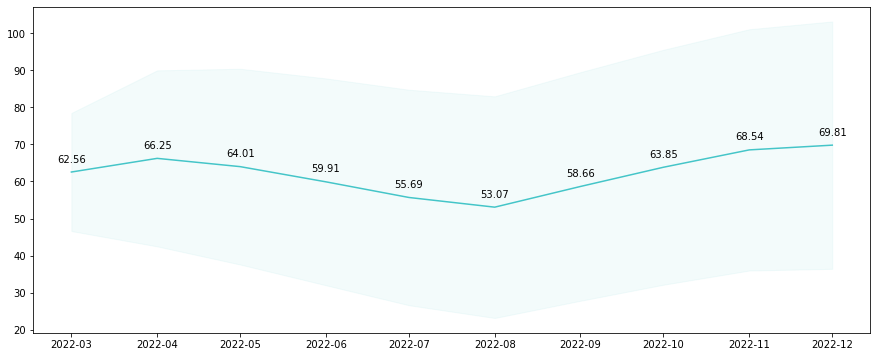

In [27]:
#Dibujo las resultados con intérvalo de confianza
plt.rcParams['figure.figsize']=(15,6)
ds=y_pred_media.reset_index()
#historico
#data
x = ds['index']
y = ds['predicted_mean']
#confidence interval
ci_low=intervalos['lower Plantilla_de_baja']
ci_upp=intervalos['upper Plantilla_de_baja']
fig, ax = plt.subplots()
ax.plot(x,y)
for i,j in zip(x,y):

    label = "{:.2f}".format(j)

    plt.annotate(label, # this is the text
                 (i,j), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax.fill_between(x, ci_low, ci_upp, color='#8ddcde', alpha=.1)

In [28]:
y_pred_media

2022-03-01    62.558362
2022-04-01    66.247200
2022-05-01    64.013147
2022-06-01    59.908592
2022-07-01    55.685384
2022-08-01    53.070207
2022-09-01    58.659975
2022-10-01    63.850580
2022-11-01    68.535176
2022-12-01    69.814607
Freq: MS, Name: predicted_mean, dtype: float64

In [29]:
intervalos

,lower Plantilla_de_baja,upper Plantilla_de_baja
2022-03-01,46.621891,78.494834
2022-04-01,42.482652,90.011748
2022-05-01,37.584811,90.441482
2022-06-01,31.983532,87.833652
2022-07-01,26.594539,84.776228
2022-08-01,23.147938,82.992476
2022-09-01,27.792381,89.527569
2022-10-01,32.133584,95.567576
2022-11-01,35.958379,101.111973
2022-12-01,36.416935,103.212279


## Obtener coste medio mensual por sustitución enfermera/o

In [30]:
#Valor de tabla retributiva 2022 para DUI de nivel 2:
#coste_mensual_bruto=1071.06+528.7+620.91+(781.15+528.7+620.91)/6
#No se tiene en cuenta importes de antiguedad como la carrera profesional y triennios ni atención continuada

In [31]:
coste_mensual_bruto=2513.58

In [32]:
inf=y_pred_media.to_frame(name='plantilla_it')

In [33]:
inf['coste_mensual']=inf*coste_mensual_bruto

In [34]:
inf['plantilla_it'].sum()

622.3432304200111

## Calcular cobertura a partir de coste_medio_mensual, previsión de plantilla de baja y crédito presupuestario

In [35]:
inf_cobertura_total=inf['coste_mensual'].sum()
inf_cobertura_total

1564309.4971191315

In [36]:
#Credito inicial en bolsa de substituciones/eventuales para Hospital Germans Trias i Pujol 2022:
Importe_inicial=7879362.4+7930089.1
Exceso_permitido=12777320.97
credito_habilitado_2022=Importe_inicial+Exceso_permitido
credito_habilitado_2022

28586772.47

In [37]:
#Gasto acumulado en subtituciones/eventuales
#gasto_enero
#gasto_febrero
gasto_en_substituciones_event_acum=4194367.95
gasto_anual_en_programas=18320654.35-gasto_en_substituciones_event_acum


In [38]:
credito_disponible=credito_habilitado_2022-gasto_en_substituciones_event_acum-gasto_anual_en_programas
credito_disponible

10266118.119999997

In [39]:
#credito_disponible_su=credito_disponible*0.5 
#el resto va para programas (25%), cobertura vacaciones (13%) y refuerzos (12%)
credito_disponible_su=credito_disponible*2/3 #2 tercios se reserva para sustituciones, el resto para refuerzos
credito_disponible_su


6844078.746666665

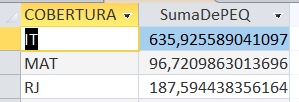

In [40]:
credito_disponible_su_it=credito_disponible_su*0.69
credito_disponible_su_it
#el resto va para sustituciones de bajas maternales (10%) y reducciones de jornadas (21%)

4722414.335199999

In [41]:
credito_disponible_su_it_enfermeras=credito_disponible_su_it*0.40
#El 41% porque es la propoción coste de personal enfermero de baja en el histórico
credito_disponible_su_it_enfermeras

1888965.7340799996

In [42]:
Cobertura_permitida=credito_disponible_su_it_enfermeras/inf_cobertura_total
Cobertura_permitida

1.2075396445260753

In [43]:
f'Con el crédito disponible de {credito_disponible_su_it_enfermeras:3,.2f} € se pueden cubrir el {Cobertura_permitida:.0%} de las bajas por IT previstas hasta final de año'

'Con el crédito disponible de 1,888,965.73 € se pueden cubrir el 121% de las bajas por IT previstas hasta final de año'

In [44]:
#formula para saber la ampliación o reducción de crédito necesária para cubrir X% de bajas
def estado_credito_SU(cobertura_deseada):
    '''cobretura expresada en %'''
    credito_necesario=inf_cobertura_total*cobertura_deseada/100
    saldo=credito_disponible_su_it_enfermeras-credito_necesario
    if saldo>0:
        return f'Se estima que sobrará {saldo:3,.2f} € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'
    else:
        return f'Se estima que faltará {-saldo:3,.2f} € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'


In [45]:
estado_credito_SU(100)

'Se estima que sobrará 324,656.24 € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'